# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [363]:
% matplotlib inline
% pprint off

import numpy as np
from skimage import io
from skimage import img_as_ubyte
from pylab import subplot
from skimage import exposure
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from PIL import Image

### import the libraries you think its necessary for your task 

Pretty printing has been turned ON


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [262]:
def cont_str (myImage):
    minimum = np.amin(myImage)
    maximum = np.amax(myImage)
    myImage = 255.0 * (myImage - minimum)/(maximum - minimum)
    return myImage.astype('uint8')

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

C:\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


(0, 255)

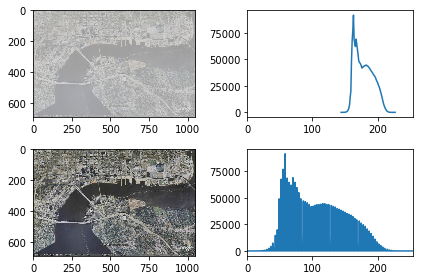

In [263]:
img_path = "./images/"
img_name = "satellite.jpg"
sat = io.imread(img_path.__add__(img_name))

subplot(2,2,1)
io.imshow(sat)
subplot(2,2,2)
hist_sat = exposure.histogram(sat, nbins=256)
plt.plot(hist_sat[1],hist_sat[0])
plt.xlim(0,255)

subplot(2,2,3)
new_img = cont_str(sat)
io.imshow(new_img)
hist_new = exposure.histogram(new_img, nbins=256)
subplot(2,2,4)
plt.plot(hist_new[1],hist_new[0])
plt.xlim(0,255)

### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [407]:
def hist_eq (myImage, min_int, max_int):
    hist, bins = np.histogram(myImage.flatten(),256,[0,255])
    normalized = hist/sum(hist)
    cummulative = np.cumsum(normalized)
    transform = cummulative * (max_int - min_int)
    transf_image = np.zeros_like(myImage)
    for i in range (0, 691):
        for j in range (0, 1048):
            transf_image[i,j] = transform[myImage[i,j]]
    trans_hist = exposure.histogram(transf_image)
    trans_hist_cum = trans_hist/sum(trans_hist)
    trans_cummulative = np.cumsum(trans_hist_cum)
    
    return transf_image, trans_cummulative

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

In [408]:
img_path = "./images/"
img_name = "satellite.jpg"
sat = io.imread(img_path.__add__(img_name))
new_imag, cdf = hist_eq (sat, 0, 255)

C:\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


**Show the transformed image and its histogram**

C:\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


(0, 255)

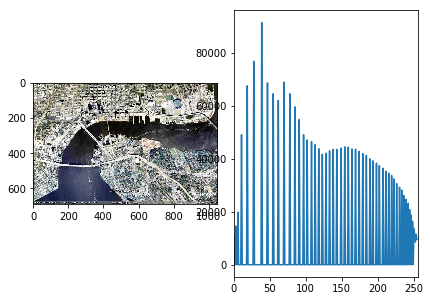

In [409]:
subplot(1,2,1)
io.imshow(new_imag)
subplot(1,2,2)
hist_sat = exposure.histogram(new_imag, nbins=256)
plt.plot(hist_sat[1],hist_sat[0])
plt.xlim(0,255)

### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

Histogram matching is a proccess applied to a histogram to transform it as close as possible to a destination histogram. First, we apply histogram equalization to the original histogram. After that, we apply inverse equalization to match the desired histogram.

In [450]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')

In [421]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match.astype('uint8')

**Creating a manual pdf following a gaussian distribution**

In [422]:
from scipy.stats import norm
max_img = 255
x = np.arange(max_img+1)
pdf_to_fit = norm.pdf(x, 150, 30)

**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(0, 255)

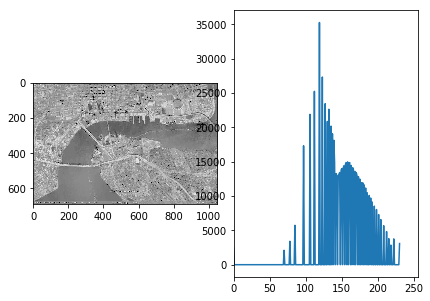

In [426]:
img_path = "./images/"
img_name = "satellite.jpg"
sat = io.imread(img_path.__add__(img_name), as_grey=True)
sat2 = img_as_ubyte(sat)
image_match = hist_match(sat2, pdf_to_fit, 0, 255)

subplot(1,2,1)
io.imshow(image_match)
subplot(1,2,2)
hist_sat = exposure.histogram(image_match, nbins=256)
plt.plot(hist_sat[1],hist_sat[0])
plt.xlim(0,255)

### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


Both of these transformations are called non-linear stretching. The logarithmic transformation is used to expand darker areas of the image. That way, pixels with lower intensity value (close to 0) will be have higher output than the initial image and the pixels with higher values are shrinked (the shrinking is less significant than the stretching). The gamma transformation is a power law transformation. Depending on the gamma factor that you apply, you can produce either significant stretching (if gamma factor < 1) or compression (if gama factor > 1) in the darker areas.

** Explain how sigmoid function enhances the image **

This function can be used to enhance a specific range of pixels values in your image. If you have most of your image between a small range of pixel values, you can use the sigmoid function to stretch this range, improving the contrast of the output image. The pixel values that are located below that range will appear very dark and those located above the range will appear brighter.